<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[View Source Code](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb) | [View Slides](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/slides/04_pytorch_custom_datasets.pdf) | [Watch Video Walkthrough](https://youtu.be/Z_ikDlimN6A?t=71010) 

# 04. PyTorch Custom Datasets

在上一个笔记本 [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/) 中，我们研究了如何在 PyTorch (FashionMNIST) 中的内置数据集上构建计算机视觉模型。

我们在机器学习中的许多不同问题上采取的步骤是相似的。

查找数据集，将数据集转换为数字，构建模型（或查找现有模型）以在这些数字中找到可用于预测的模式。

PyTorch 有许多用于大量机器学习基准测试的内置数据集，但是，您通常希望使用自己的**自定义数据集(Custom Datasets)**。

## What is a custom dataset?

**自定义数据集**是与您正在处理的特定问题相关的数据集合。

本质上，**自定义数据集**几乎可以包含任何内容。

例如，如果我们正在构建像 [Nutrify](https://nutrify.app) 这样的食物图像分类应用程序，我们的自定义数据集可能是食物图像。

或者，如果我们试图建立一个模型来分类网站上基于文本的评论是正面的还是负面的，我们的自定义数据集可能是现有客户评论及其评级的示例。

或者，如果我们试图构建一个声音分类应用程序，我们的自定义数据集可能是声音样本及其样本标签。

或者，如果我们试图为在我们网站上购买商品的客户构建推荐系统，我们的自定义数据集可能是其他人购买的产品的示例。
<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-domain-libraries.png" alt="different pytorch domain libraries can be used for specific PyTorch problems" width=1000/>

*PyTorch 包含许多现有函数，用于加载自定义数据集 [`TorchVision`](https://pytorch.org/vision/stable/index.html), [`TorchText`](https://pytorch.org/text/stable/index.html), [`TorchAudio`](https://pytorch.org/audio/stable/index.html) and [`TorchRec`](https://pytorch.org/torchrec/)*

但有时内置的函数不够实现想要的功能。

此时, 可以通过继承 `torch.utils.data.Dataset`自定义我们的数据集。

## What we're going to cover

我们将应用我们在 [notebook 01](https://www.learnpytorch.io/01_pytorch_workflow/) 和 [notebook 02](https://www.learnpytorch.io/02_pytorch_classification/) 中介绍的 PyTorch 工作流 到计算机视觉问题。

但是，我们将使用我们自己的比萨、牛排和寿司图像数据集，而不是使用内置的 PyTorch 数据集。

目标是加载这些图像，然后建立一个模型来训练和预测它们。

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-food-vision-layout.png" alt="building a pipeline to load in food images and then building a pytorch model to classify those food images" width=800 />

*我们将使用`torchvision.datasets`以及我们自己的自定义`Dataset`类来加载食物图像，然后我们将构建一个 PyTorch 计算机视觉模型，希望能够对它们进行分类。*

Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **0. Importing PyTorch and setting up device-agnostic code** | Let's get PyTorch loaded and then follow best practice to setup our code to be device-agnostic.  |
| **1. Get data** | We're going to be using our own **custom dataset** of pizza, steak and sushi images. |
| **2. Become one with the data (data preparation)** | At the beginning of any new machine learning problem, it's paramount to understand the data you're working with. Here we'll take some steps to figure out what data we have. |
| **3. Transforming data** |Often, the data you get won't be 100% ready to use with a machine learning model, here we'll look at some steps we can take to *transform* our images so they're ready to be used with a model. | 
| **4. Loading data with `ImageFolder` (option 1)** | PyTorch has many in-built data loading functions for common types of data. `ImageFolder` is helpful if our images are in standard image classification format. |
| **5. Loading image data with a custom `Dataset`** | What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of `torch.utils.data.Dataset`. |
| **6. Other forms of transforms (data augmentation)** | Data augmentation is a common technique for expanding the diversity of your training data. Here we'll explore some of `torchvision`'s in-built data augmentation functions. |
| **7. Model 0: TinyVGG without data augmentation** | By this stage, we'll have our data ready, let's build a model capable of fitting it. We'll also create some training and testing functions for training and evaluating our model. |
| **8. Exploring loss curves** | Loss curves are a great way to see how your model is training/improving over time. They're also a good way to see if your model is **underfitting** or **overfitting**. |
| **9. Model 1: TinyVGG with data augmentation** | By now, we've tried a model *without*, how about we try one *with* data augmentation? |
| **10. Compare model results** | Let's compare our different models' loss curves and see which performed better and discuss some options for improving performance. |
| **11. Making a prediction on a custom image** | Our model is trained to on a dataset of pizza, steak and sushi images. In this section we'll cover how to use our trained model to predict on an image *outside* of our existing dataset. |

## Where can can you get help?

All of the materials for this course [live on GitHub](https://github.com/mrdbourke/pytorch-deep-learning).

If you run into trouble, you can ask a question on the course [GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions) there too.

And of course, there's the [PyTorch documentation](https://pytorch.org/docs/stable/index.html) and [PyTorch developer forums](https://discuss.pytorch.org/), a very helpful place for all things PyTorch. 

## 0. Importing PyTorch and setting up device-agnostic code

In [12]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'1.10.2'

And now let's follow best practice and setup device-agnostic code.

> **Note:** If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via `Runtime -> Change runtime type -> Hardware accelerator -> GPU`. If you do this, your runtime will likely reset and you'll have to run all of the cells above by going `Runtime -> Run before`.

In [54]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

首先我们需要一些数据。

就像任何好的烹饪节目一样，一些数据已经为我们准备好了。

我们将从小处着手。

因为我们还不打算训练最大的模型或使用最大的数据集。

机器学习是一个迭代过程，从小处着手，开始工作并在必要时增加。

我们使用的数据集是[Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)的一部分。

Food101 是流行的计算机视觉基准，因为它包含 101 种不同食物的 1000 张图像，总共 101,000 张图像（75,750 个训练， 25,250 个测试）。

你能想到 101 种不同的食物吗？

你能想出一个对 101 种食物进行分类的计算机程序吗？

我可以。

机器学习模型！

具体来说，像我们在 [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/) 中介绍的 PyTorch 计算机视觉模型。

不过，我们将从 3 种食物类开始，而不是 101 种食物：比萨、牛排和寿司。

而不是每类 1,000 张图像，我们将从随机 10% 开始（从小处开始，必要时增加）。

如果您想查看数据的来源，请查看以下资源：
* 原创 [Food101 数据集和论文网站](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)。
* [`torchvision.datasets.Food101`](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html) - 我为此笔记本下载的数据版本。
* [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) - 我用来格式化 Food101 数据集的笔记本 这个笔记本。
* [`data/pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip) - 来自 Food101 的披萨、牛排和寿司图像的 zip 存档 ，使用上面链接的笔记本创建。

让我们编写一些代码来从 GitHub 下载格式化数据。

> **注意：** 我们将要使用的数据集已针对我们想要使用的用途进行了预格式化。 但是，您通常必须针对您正在处理的任何问题格式化自己的数据集。 这是机器学习领域的常规做法。

>**注意2**：由于网络原因，在中国下载数据集可能遇到一些问题。很多时候需要自己通过各种方法手动下载（译者注）。

In [11]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",verify=False)
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data\pizza_steak_sushi directory exists.


## 2. Become one with the data (data preparation)

数据集下载！

是时候与它合一了。

这是构建模型之前的另一个重要步骤。

正如亚伯拉罕损失函数所说......

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-abraham-lossfunction.png" alt="tweet by mrdbourke, 如果我有 8 个小时来构建机器学习模型，我会花前 6 个小时来准备我的数据集" width=800/>

*数据准备是最重要的。 在构建模型之前，先与数据合一。 问：我想在这里做什么？ 资源: [@mrdbourke Twitter](https://twitter.com/mrdbourke).*

什么是检查数据并与之合二为一？

在开始项目或构建任何类型的模型之前，了解您正在使用的数据非常重要。

在我们的例子中，我们有标准图像分类格式的披萨、牛排和寿司的图像。

图像分类格式在以特定类名命名的单独目录中包含单独的图像类。

例如，“pizza”的所有图像都包含在“pizza/”目录中。

这种格式在许多不同的图像分类基准中都很流行，包括 [ImageNet](https://www.image-net.org/)（最流行的计算机视觉基准数据集）。

您可以在下面看到一个存储格式的示例，图像编号是任意的。

```
pizza_steak_sushi/ <- overall dataset folder
    train/ <- training images
        pizza/ <- class name as folder name
            image01.jpeg
            image02.jpeg
            ...
        steak/
            image24.jpeg
            image25.jpeg
            ...
        sushi/
            image37.jpeg
            ...
    test/ <- testing images
        pizza/
            image101.jpeg
            image102.jpeg
            ...
        steak/
            image154.jpeg
            image155.jpeg
            ...
        sushi/
            image167.jpeg
            ...
```

目标是**采用此数据存储结构并将其转换为可与 PyTorch 一起使用的数据集**。

> **注意：** 您处理的数据结构会因您处理的问题而异。 但前提仍然存在：与数据融为一体，然后找到一种方法将其最好地转化为与 PyTorch 兼容的数据集。

我们可以通过编写一个小帮助函数来检查数据目录中的内容，以遍历每个子目录并计算存在的文件。

为此，我们将使用 Python 的内置 [`os.walk()`](https://docs.python.org/3/library/os.html#os.walk)。

In [13]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [14]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


很棒！

看起来每个类有75张图片作为训练集，25张图片作为测试集。


这是Food101的一小部分，但足够我们开始训练了。

你可以在 [data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb)查看如何制作自定义的数据集。

现在，我们设置一下训练目录和测试目录。

In [15]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image

我们看到了文件夹的组织形式。

现在是可视化时间！

让我们编写一些代码：
1. 使用 [`pathlib.Path.glob()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob) 获取所有图像路径以查找所有 以`.jpg`结尾的文件。
2. 使用 Python 的 [`random.choice()`](https://docs.python.org/3/library/random.html#random.choice) 选择一个随机图像路径。
3. 使用[`pathlib.Path.parent.stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.parent)获取图像类名。
4. 由于我们正在处理图像，我们将使用 [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image. html#PIL.Image.open)（PIL 代表 Python 图像库）。
5. 然后我们将显示图像并打印一些元数据。

Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


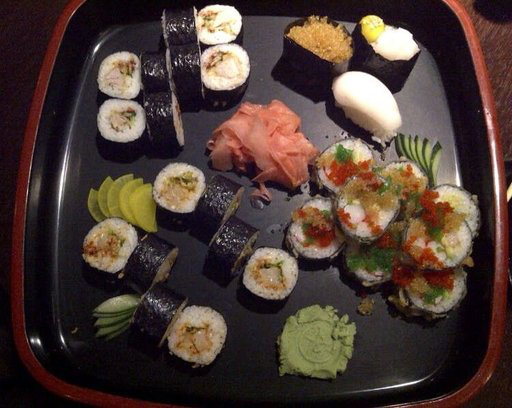

In [16]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

也可以用 [`matplotlib.pyplot.imshow()`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.imshow.html)进行可视化,只是我们需要将图片先转换成NumPy array。

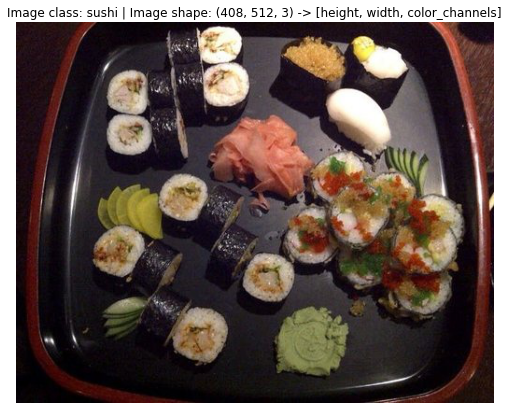

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## 3. Transforming data 

现在，如果我们想将图像数据加载到 PyTorch 中怎么办？

在我们可以将图像数据与 PyTorch 一起使用之前，我们需要：

1. 把它变成张量（图像的数字表示）。
2. 将其转换为 `torch.utils.data.Dataset` 和随后的 `torch.utils.data.DataLoader`，我们将它们简称为 `Dataset` 和 `DataLoader`。

PyTorch 有几种不同类型的预构建数据集和数据集加载器，具体取决于您正在处理的问题。

| **Problem space** | **Pre-built Datasets and Functions** |
| ----- | ----- |
| **Vision** | [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) |
| **Audio** | [`torchaudio.datasets`](https://pytorch.org/audio/stable/datasets.html) |
| **Text** | [`torchtext.datasets`](https://pytorch.org/text/stable/datasets.html) |
| **Recommendation system** | [`torchrec.datasets`](https://pytorch.org/torchrec/torchrec.datasets.html) |

由于我们正在处理视觉问题，我们将查看 `torchvision.datasets` 的数据加载功能以及 [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms .html) 用于准备我们的数据。

让我们先导入相关的库。

In [18]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 用 `torchvision.transforms`变换数据

我们有图像文件夹，但在我们可以将它们与 PyTorch 一起使用之前，我们需要将它们转换为张量。

我们可以做到这一点的一种方法是使用“torchvision.transforms”模块。

`torchvision.transforms` 包含许多预先构建的方法来格式化图像，将它们转换为张量，甚至进行**数据增强**（改变数据以使模型更难学习的做法，稍后介绍）。

要获得使用 `torchvision.transforms` 的经验，让我们编写一系列转换步骤：
1. 使用 [`transforms.Resize()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize) 调整图像大小（从大约 512x512 到 64x64 , 与 [CNN Explainer 网站](https://poloclub.github.io/cnn-explainer/) 上的图像相同的形状。
2. 使用 [`transforms.RandomHorizo​​ntalFlip()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizo​​ntalFlip.html#torchvision.transforms.RandomHorizo​​ntalFlip) 在水平方向上随机翻转我们的图像（这个可以被认为是一种数据增强形式，因为它会人为地改变我们的图像数据）。
3. 使用 [`transforms.ToTensor()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.到张量）。

我们可以使用 [`torchvision.transforms.Compose()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) 组合所有这些步骤。

In [19]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

现在我们已经有了变换的组合，让我们编写一个函数来在各种图像上尝试它们。

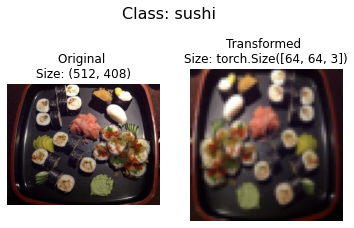

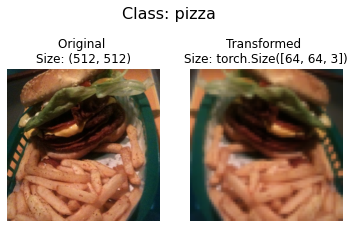

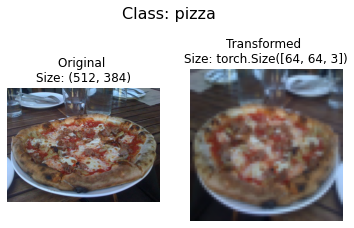

In [20]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

好的！

我们现在有了一种使用“torchvision.transforms”将图像转换为张量的方法。

如果需要，我们还会操纵它们的大小和方向（某些模型更喜欢不同大小和形状的图像）。

通常，图像的形状越大，模型可以恢复的信息越多。

例如，尺寸为 `[256, 256, 3]` 的图像将比尺寸为 `[64, 64, 3]` 的图像多 16 倍像素 (`(256*256*3)/(64*64* 3)=16`)。

然而，更多的像素需要更多的计算。因此尺寸的选择需要在信息量和计算上做一个折中。

> **练习：** 尝试注释掉 `data_transform` 中的一个变换并再次运行绘图函数 `plot_transformed_images()`，会发生什么？

## 4. Option 1: Loading Image Data Using [`ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder)

是时候将我们的图片用`Dataset` 变成PyTorch可用的数据了。

由于我们的数据是标准的图片分类类型,可以使用 [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder).

我们可以将目标图像目录的文件路径以及我们希望对图像执行的一系列转换传递给它。

让我们在我们的数据文件夹 `train_dir` 和 `test_dir` 上进行测试，通过 `transform=data_transform` 将我们的图像转换为张量。

In [21]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


Beautiful!

看上去 PyTorch 注册了我们的 `Dataset`。

让我们用 `classes` 和 `class_to_idx` 属性检查一下。

In [22]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [23]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [24]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

好的！ 看起来我们以后可以使用这些来参考。

我们的图像和标签怎么样？

他们看起来怎么样？

我们可以在 `train_data` 和 `test_data` `Dataset` 上建立索引来查找样本及其目标标签。Nice! Looks like we'll be able to use these to reference for later.

In [25]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

我们的图片现在是tensor形式了(with shape `[3, 64, 64]`) 而标签是整数（和类别相关） (as referenced by the `class_to_idx` attribute).

用 `matplotlib`可视化一个怎么样?

需要先 permute (rearrange the order of its dimensions) so it's compatible.

现在我们的图像尺寸格式为“CHW”（颜色通道、高度、宽度），但“matplotlib”更喜欢“HWC”（高度、宽度、颜色通道）。

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


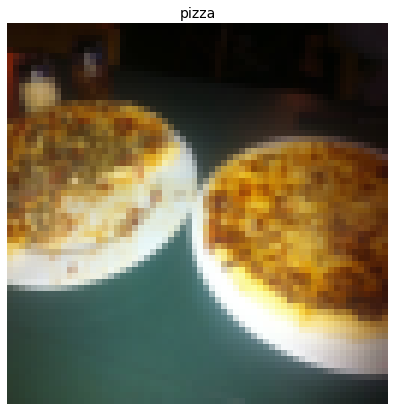

In [26]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

请注意，图像现在像素化程度更高（质量更低）。

这是因为它的大小从“512x512”调整为“64x64”像素。

这里的直觉是，如果您认为图像更难识别正在发生的事情，那么模型很可能也会发现它更难理解。

### 4.1 Turn loaded images into `DataLoader`'s

我们已经将图像作为 PyTorch 的“Dataset”，但现在让我们将它们变成“DataLoader”。

我们将使用 [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)来实现。

将我们的 `Dataset` 转换为 `DataLoader` 使它们可迭代，因此模型可以通过学习样本和目标（特征和标签）之间的关系。

为简单起见，我们将使用 `batch_size=1` 和 `num_workers=1`。

什么是`num_workers`？

好问题。

它定义了将创建多少个子进程来加载您的数据。

可以这样想，`num_workers` 设置的值越高，PyTorch 用于加载数据的计算能力就越大。

就个人而言，我通常通过 Python 的 [`os.cpu_count()`](https://docs.python.org/3/library/os.html#os.cpu_count) 将其设置为我机器上的 CPU 总数。

这确保了 `DataLoader` 使用尽可能多的核心来加载数据。

> **注意：**更多参数你可以在[PyTorch文档](https://pytorch.org/docs/stable/data.html#torch)中使用`torch.utils.data.DataLoader`来熟悉 .utils.data.DataLoader）。

In [28]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1e53b3d6e20>,
 <torch.utils.data.dataloader.DataLoader at 0x1e53b3d6e80>)

现在我们的数据是可迭代的了。
让我们查看其形状。

In [29]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


我们现在可以使用这些带有训练和测试循环的“DataLoader”来训练模型。

但在此之前，让我们看一下加载图像（或几乎任何其他类型的数据）的另一个选项。

## 5. Option 2: Loading Image Data with a Custom `Dataset`

如果不存在像 [`torchvision.datasets.ImageFolder()`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder) 这样的预构建“数据集”创建者怎么办？

或者不存在针对您特定问题的解决方案？

好吧，你可以建立自己的。

但是等等，创建自己的自定义方式来加载“数据集”的优缺点是什么？

| Pros of creating a custom `Dataset` | Cons of creating a custom `Dataset` |
| ----- | ----- |
|可以为几乎任何数据创建`Dataset`| 即使您*可以*用几乎任何东西创建一个“数据集”，但这并不意味着它会起作用。 | 
|不再被内置`Dataset` 限制 |使用自定义`Dataset`通常会导致编写更多代码，这可能容易出现错误或性能问题。 |

为了看到这一点，让我们通过继承 `torch.utils.data.Dataset`（PyTorch 中所有 `Dataset` 的基类）来复制 `torchvision.datasets.ImageFolder()`。

我们将从导入我们需要的模块开始：
* Python 的 `os` 用于处理目录（我们的数据存储在目录中）。
* Python 的 `pathlib` 用于处理文件路径（我们的每个图像都有一个唯一的文件路径）。
* `torch` 适用于 PyTorch 的所有内容。
* PIL 的 `Image` 类用于加载图像。
* `torch.utils.data.Dataset` 继承并创建我们自己的自定义 `Dataset`。
* `torchvision.transforms` 将我们的图像转换为张量。
* 来自 Python 的 `typing` 模块的各种类型，用于向我们的代码添加类型提示。

> **注意：**您可以为自己的数据集自定义以下步骤。 前提仍然是：编写代码以您想要的格式加载数据。

In [30]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

还记得我们的 `torchvision.datasets.ImageFolder()` 实例是如何允许我们使用 `classes` 和 `class_to_idx` 属性的吗？

In [31]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

让我们编写一个辅助函数，该函数能够在给定目录路径的情况下创建类名列表和"类名:索引"的字典。

为此，我们将：
1. 使用`os.scandir()`获取类名，遍历一个目标目录（理想情况下该目录是标准图像分类格式）。
2. 如果找不到类名，则引发错误（如果发生这种情况，目录结构可能有问题）。
3. 将类名转换成数字标签字典，每个类一个。

在我们编写完整函数之前，让我们看一下步骤 1 的一个小例子。

In [23]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data\pizza_steak_sushi\train
Class names found: ['pizza', 'steak', 'sushi']


Excellent!

How about we turn it into a full function?

In [35]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

Looking good!

Now let's test out our `find_classes()` function.

In [36]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

Woohoo! Looking good!

现在我们准备构建我们自己的自定义`Dataset`。

我们将构建一个来复制`torchvision.datasets.ImageFolder()`的功能。

这将是一个很好的做法，此外，它还将揭示制作您自己的自定义“数据集”所需的一些步骤。

这将是一个相当多的代码......但没有我们无法处理的！

让我们将其分解为下面步骤：
1. 继承 `torch.utils.data.Dataset`.
2. 用 `targ_dir`  (the target data directory)和 `transform` (so we have the option to transform our data if needed)参数初始化。
3. 创建属性：`paths`（目标图像的路径）、`transform`（我们可能想要使用的变换，可以是`None`）、`classes`和`class_to_idx`（来自我们的`find_classes() `函数）。
4. 创建一个从文件加载图像并返回它们的函数，这可以使用`PIL`或[`torchvision.io`]（https://pytorch.org/vision/stable/io.html#image）（用于输入/ 视觉数据的输出）。
5. 重写 `torch.utils.data.Dataset` 的 `__len__` 方法以返回 `Dataset` 中的样本数。 这样您就可以调用 `len(Dataset)`。
6. 重写 `torch.utils.data.Dataset` 的 `__getitem__` 方法以从 `Dataset` 返回单个样本。

Let's do it!

In [37]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

哇！ 一大堆代码。

这是创建自己的自定义“数据集”的缺点之一。

然而，现在我们已经编写了一次，我们可以将它与其他一些有用的数据函数一起移动到一个 `.py` 文件中，例如 `data_loader.py` 并在以后重用它。

在我们测试新的“ImageFolderCustom”类之前，让我们创建一些转换来准备我们的图像。

In [38]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

现在到了关键时刻！

让我们使用我们自己的 `ImageFolderCustom`类将我们的训练图像（包含在 `train_dir` 中）和我们的测试图像（包含在 `test_dir` 中）转换为 `Dataset`。

In [39]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, 
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x1e53b4ba6d0>,
 <__main__.ImageFolderCustom at 0x1e53b4ba340>)

没有报错，但是它能工作吗?

让我们尝试在新的 `Dataset` 上调用 `len()` 并检查 `classes` 和 `class_to_idx` 属性。

In [40]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [41]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [42]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

`len(test_data_custom) == len(test_data)` and `len(test_data_custom) == len(test_data)` Yes!!!

看起来它奏效了。

我们也可以检查由 `torchvision.datasets.ImageFolder()` 类创建的 `Dataset` 是否相等。

In [43]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


嗬嗬！

看我们走！

三个“真”！

你没有比这更好的了。

我们提升一个档次并绘制一些随机图像来测试我们的 `__getitem__` 覆盖如何？

### 5.3 Create a function to display random images

你知道该干嘛了!

可视化时间！

让我们创建一个名为 `display_random_images()` 的辅助函数，帮助我们可视化 `Dataset` 中的图像。
具体来说：

1. 接受一个`Dataset`和一些其他参数，例如`classes`（我们的目标类的名称）、要显示的图像数量（`n`）和一个随机种子。
2. 为防止显示失控，我们将 `n` 限制为 10 张图像。
3. 为可重复的地块设置随机种子（如果设置了“种子”）。
4. 获取随机样本索引列表（我们可以使用 Python 的 `random.sample()` 来绘制）。
5. 设置一个`matplotlib`图。
6. 遍历第 4 步中找到的随机样本索引，并使用`matplotlib`绘制它们。
7. 确保样本图像的形状为“HWC”（高度、宽度、颜色通道），以便我们绘制它们。

In [44]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

What a good looking function!

Let's test it out first with the `Dataset` we created with `torchvision.datasets.ImageFolder()`.

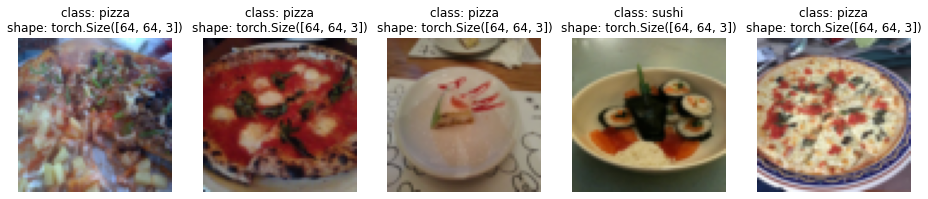

In [45]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

现在使用我们自己的 `ImageFolderCustom` 创建的`Dataset`。

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


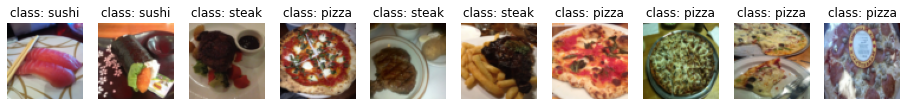

In [46]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom, 
                      n=12, 
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images

Nice!!!

看起来我们的 `ImageFolderCustom` 就像我们希望的那样工作。

### 5.4 Turn custom loaded images into `DataLoader`'s 

我们有一种方法可以通过我们的 `ImageFolderCustom` 类将我们的原始图像转换为`Dataset`（映射到标签的特征或`X` 映射到`y`'s）。

现在我们如何将自定义的“Dataset”变成“DataLoader”？

通过使用 `torch.utils.data.DataLoader()` ！

因为我们自定义的 `Dataset` 的子类 `torch.utils.data.Dataset`，我们可以直接通过 `torch.utils.data.DataLoader()` 使用它们。

我们可以使用与之前非常相似的步骤，除了这次我们将使用我们自定义创建的“数据集”。

In [47]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x1e53b6c6610>,
 <torch.utils.data.dataloader.DataLoader at 0x1e53b6af430>)

检查一下shape?

In [48]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


现在让我们深入了解一些其他形式的数据转换。

## 6. Other forms of transforms (数据增强data augmentation)

我们已经在我们的数据上看到了一些转换，但还有更多。

您可以在 [`torchvision.transforms` 文档](https://pytorch.org/vision/stable/transforms.html) 中查看它们。

转换的目的是以某种方式改变你的图像。

这可能会将您的图像变成张量（正如我们之前所见）。

或裁剪它或随机擦除一部分或随机旋转它们。

进行这种转换通常被称为**数据增强**。

**数据增强**是改变数据的过程，您可以*人工*增加训练集的多样性。

在这个 *人工* 更改的数据集上训练模型有望产生一个能够更好地 * 泛化 * 的模型（它学习的模式对未来看不见的示例更加稳健）。

您可以在 PyTorch 的 [Illustration of Transforms 示例](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#illustration-of-transforms) 中看到许多使用 `torchvision.transforms` 对图像执行数据增强的不同示例 ）。

但是让我们自己试一试。

机器学习就是利用随机性的力量，研究表明随机变换（如 [`transforms.RandAugment()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#randaugment) 和 [ `transforms.TrivialAugmentWide()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#trivialaugmentwide)）通常比手工挑选的变换表现更好。
The idea behind [TrivialAugment](https://arxiv.org/abs/2103.10158) is... well, trivial. 

您有一组变换，并且您随机选择其中的一些变换来在图像上执行，并且在给定范围之间以随机幅度执行（幅度越高意味着强度越大）。

The PyTorch team even [used TrivialAugment it to train their latest state-of-the-art vision models](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements).

![trivial augment data augmentation being used for PyTorch state of the art training](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-trivial-augment-being-using-in-PyTorch-resize.png)

*Trivial Augment 是最近对各种 PyTorch 视觉模型进行最先进的培训升级时使用的成分之一。*
我们在我们自己的一些图像上测试它怎么样？

在 `transforms.TrivialAugmentWide()` 中要注意的主要参数是 `num_magnitude_bins=31`。

它定义了强度值将被选择多少范围以应用特定变换，“0”表示无范围，“31”表示最大范围（最高强度的最高机会）。

我们可以将 `transforms.TrivialAugmentWide()` 合并到 `transforms.Compose()` 中。

In [49]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

> **注意：**您通常不对测试集执行数据扩充。 数据增强的想法是*人工*增加训练集的多样性，以更好地预测测试集。
>
> 但是，您确实需要确保将测试集图像转换为张量。 我们也将测试图像的大小调整为与训练图像相同的大小，但是，如有必要，可以对不同大小的图像进行推断（尽管这可能会改变性能）。

漂亮，现在我们有了训练转换（有数据增强）和测试转换（没有数据增强）。

让我们测试一下我们的数据增强！

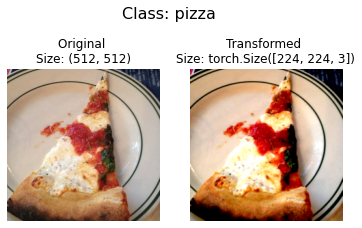

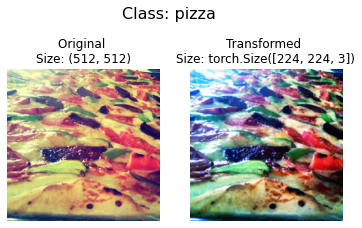

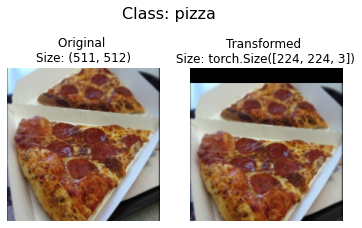

In [50]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

尝试运行上面的单元格几次，看看原始图像在经过变换时如何变化。

## 7. Model 0: TinyVGG without data augmentation

好的，我们已经了解了如何将数据从文件夹中的图像转换为转换后的张量。

现在让我们构建一个计算机视觉模型，看看我们是否可以对图像是披萨、牛排还是寿司进行分类。

首先，我们将从一个简单的变换开始，仅将图像大小调整为 `(64, 64)` 并将它们转换为张量。

### 7.1 Creating transforms and loading data for Model 0

In [51]:
# Create simple transform
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

太好了，现在我们有了一个简单的转换，让我们：
1. 加载数据，首先将我们的每个训练和测试文件夹转换为具有 `torchvision.datasets.ImageFolder()` 的 `Dataset`
2. 然后使用 `torch.utils.data.DataLoader()` 进入 `DataLoader`。
     * 我们将 `batch_size=32` 和 `num_workers` 设置为我们机器上尽可能多的 CPU（这取决于您使用的机器）。

In [52]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 8 workers.


(<torch.utils.data.dataloader.DataLoader at 0x1e53b6870a0>,
 <torch.utils.data.dataloader.DataLoader at 0x1e53b8d9c40>)

`DataLoader`'s created! 

Let's build a model.

### 7.2 Create TinyVGG model class

在 [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/#7-model-2-building-a-convolutional-neural-network-cnn) 中，我们使用了来自 [CNN Explainer website] 的 TinyVGG 模型 （https://poloclub.github.io/cnn-explainer/）。

让我们重新创建相同的模型，只是这次我们将使用彩色图像而不是灰度图像（对于 RGB 像素，使用`in_channels=3` 而不是`in_channels=1`）。

In [55]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

> **注意：** 在 GPU 上加速深度学习模型计算的方法之一是利用 **operator fusion**。
>
> 这意味着在我们上面模型的 `forward()` 方法中，我们不是每次都调用一个层块并重新分配 `x`，而是依次调用每个块（参见 `forward()` 方法的最后一行 以上面的模型为例）。
>
> 这节省了重新分配“x”（memory heavy）所花费的时间，并且只专注于“x”上的计算。
>
> 请参阅 Horace He 的 [*Making Deep Learning Go Brrrr From First Principles*](https://horace.io/brrr_intro.html)，了解有关如何加速机器学习模型的更多方法。

现在这是一个漂亮的模型！

我们如何通过对单个图像的前向传递来测试它？


### 7.3 Try a forward pass on a single image (to test the model)

测试模型的一个好方法是对单个数据进行前向传递。

这也是测试我们不同层的输入和输出形状的便捷方法。

要对单个图像进行前向传递，让我们：
1. 从`DataLoader`中获取一批图片和标签。
2. 从批处理中获取单个图像，然后对图像执行“unsqueeze()”，使其批处理大小为“1”（因此其形状适合模型）。
3. 对单个图像进行推理（确保将图像发送到目标`设备`）。
4. 打印出正在发生的事情并使用 `torch.softmax()` 将模型的原始输出 logits 转换为预测概率（因为我们正在处理多类数据），并使用 `torch.argmax() 将预测概率转换为预测标签 )`

In [57]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0637, 0.0615, 0.0382]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3364, 0.3357, 0.3279]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')

Actual label:
1


太棒了，看起来我们的模型正在输出我们期望它输出的东西。

您可以多次运行上面的单元格，每次都可以预测不同的图像。

您可能会注意到预测通常是错误的。

这是意料之中的，因为模型还没有经过训练，它本质上是在使用随机权重进行猜测。

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

使用`print(model)` 打印出我们的模型让我们了解我们的模型发生了什么。

我们可以在整个 `forward()` 方法中打印出数据的形状。

但是，从我们的模型中获取信息的一种有用方法是使用 [`torchinfo`](https://github.com/TylerYep/torchinfo)。

`torchinfo` 带有一个 `summary()` 方法，该方法采用 PyTorch 模型以及 `input_shape` 并返回张量在模型中移动时发生的情况。

> **注意：** 如果您使用的是 Google Colab，则需要安装 `torchinfo`。

In [59]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

好的！

`torchinfo.summary()` 的输出为我们提供了有关我们模型的大量信息。

例如`Total params`，我们模型中的参数总数，`Estimated Total Size (MB)`，这是我们模型的大小。

您还可以看到输入和输出形状的变化，因为某个 `input_size` 的数据在我们的模型中移动。

现在，我们的参数数量和总模型大小都很低。

这是因为我们从一个小模型开始。

如果我们以后需要增加它的大小，我们可以。

### 7.5 Create train & test loop functions 

我们有数据，我们有一个模型。

现在让我们创建一些训练和测试循环函数来在训练数据上训练我们的模型并在测试数据上评估我们的模型。

为了确保我们可以再次使用这些训练和测试循环，我们将对它们进行函数化。

具体来说，我们将创建三个函数：
1. `train_step()` - 接受模型、`DataLoader`、损失函数和优化器，并在`DataLoader`上训练模型。
2. `test_step()` - 接收模型、`DataLoader` 和损失函数，并在`DataLoader` 上评估模型。
3. `train()` - 对给定数量的 epoch 一起执行 1. 和 2. 并返回结果字典。

> **注意：** 我们也在 [notebook 01](https://www.learnpytorch.io/01_pytorch_workflow/#creating-an-optimization-loop-in-pytorch) 中介绍了 PyTorch 优化循环中的步骤 作为[非官方 PyTorch 优化循环歌曲](https://youtu.be/Nutpusq_AFw)，我们在 [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/#62-functionizing- 训练和测试循环）。

让我们从构建 `train_step()` 开始。

因为我们在 `DataLoader` 中处理批次，所以我们将在训练期间累积模型损失和准确度值（通过将每个批次相加），然后在返回之前最后调整它们。

In [63]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

呜呼！ `train_step()` 函数完成。

现在让我们对 `test_step()` 函数做同样的事情。

这里的主要区别是 `test_step()` 不会采用优化器，因此不会执行梯度下降。

但由于我们将进行推理，我们将确保打开 `torch.inference_mode()` 上下文管理器以进行预测。

In [64]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

Excellent!



### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

现在我们需要一种方法来将我们的 `train_step()` 和 `test_step()` 函数放在一起。

为此，我们将它们打包在一个`train()` 函数中。

该函数将训练模型并对其进行评估。

具体来说，它将：
1. 接收一个模型、一个用于训练和测试集的`DataLoader`、一个优化器、一个损失函数以及每个训练和测试步骤执行多少个 epoch。
2. 为 `train_loss`、`train_acc`、`test_loss` 和 `test_acc` 值创建一个空的结果字典（我们可以随着训练的进行填充它）。
3. 循环训练和测试步骤函数数个 epoch。
4. 打印出每个 epoch 结束时发生的事情。
5. 使用每个 epoch 更新的指标更新空结果字典。
6. 返回填好的

为了跟踪我们经历的 epoch 数量，让我们从 `tqdm.auto` 导入 `tqdm`（[`tqdm`](https://github.com/tqdm/tqdm)是Python的流行的进度条。 `tqdm.auto` 的进度条库会自动决定哪种进度条最适合您的计算环境，例如 Jupyter Notebook 与 Python 脚本）。

In [65]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### 7.7 Train and Evaluate Model 0

好的，好的，好的，我们已经获得了训练和评估模型所需的所有要素。

是时候将我们的 `TinyVGG` 模型、`DataLoader` 和 `train()` 函数放在一起，看看我们是否可以构建一个能够区分披萨、牛排和寿司的模型！

让我们重新创建 `model_0`（我们不需要，但为了完整起见我们会这样做），然后调用我们的 `train()` 函数并传入必要的参数。

为了让我们的实验快速进行，我们将训练我们的模型 **5 epochs**（尽管您可以根据需要增加此值）。

至于**优化器**和**损失函数**，我们将使用`torch.nn.CrossEntropyLoss()`（因为我们正在处理多类分类数据）和`torch.optim.Adam( )`，学习率分别为`1e-3`。

要查看需要多长时间，我们将导入 Python 的 [`timeit.default_timer()`](https://docs.python.org/3/library/timeit.html#timeit.default_timer) 方法来计算训练时间 .

In [79]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1360 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0847 | train_acc: 0.4258 | test_loss: 1.1620 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1157 | train_acc: 0.2930 | test_loss: 1.1697 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0956 | train_acc: 0.4141 | test_loss: 1.1384 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0985 | train_acc: 0.2930 | test_loss: 1.1426 | test_acc: 0.1979
Total training time: 46.314 seconds


唔...

看起来我们的模型表现得很糟糕。

不过暂时没关系，我们会继续坚持的。

有哪些方法可以改进它？

> **Note:** Check out the [*Improving a model (from a model perspective)* section in notebook 02](https://www.learnpytorch.io/02_pytorch_classification/#5-improving-a-model-from-a-model-perspective) for ideas on improving our TinyVGG model.

### 7.8 Plot the loss curves of Model 0

从我们的 `model_0` 训练的打印输出来看，它看起来并不太好。

但是我们可以通过绘制模型的**损失曲线**来进一步评估它。

**损失曲线**显示模型随时间变化的结果。

它们是查看模型在不同数据集（例如训练和测试）上的表现的好方法。

让我们创建一个函数来绘制 `model_0_results` 字典中的值。

In [67]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

We'll need to extract each of these keys and turn them into a plot.

In [68]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

Okay, let's test our `plot_loss_curves()` function out.

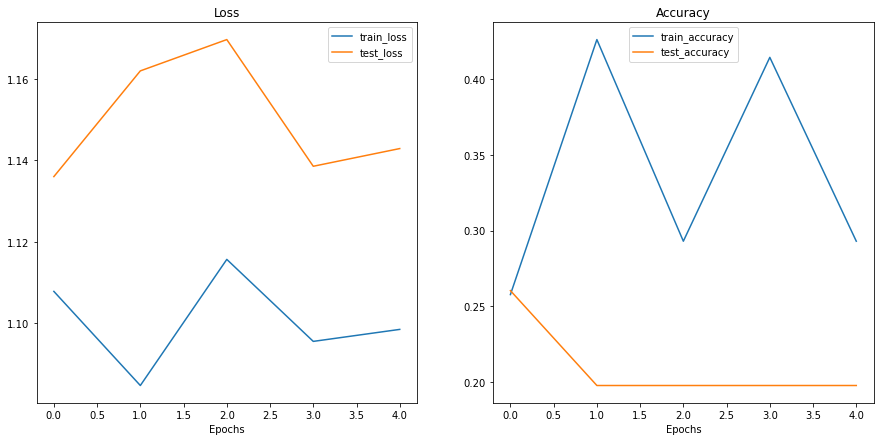

In [69]:
plot_loss_curves(model_0_results)

哇。

好像东西都乱七八糟了……

但我们有点知道，因为我们的模型在训练期间的打印结果并没有显示出太多的希望。

您可以尝试更长时间地训练模型，看看当您在更长的时间范围内绘制损失曲线时会发生什么。

## 8. What should an ideal loss curve look like?

查看训练和测试损失曲线是了解您的模型是否**过拟合**的好方法。

过拟合模型是在训练集上比验证/测试集表现更好（通常有相当大的差距）的模型。

如果您的训练损失远低于测试损失，则您的模型是**过度拟合**。

例如，它对训练中的模式学习得很好，而这些模式并没有推广到测试数据。

另一方面是当你的训练和测试损失没有你想要的那么低时，这被认为是**欠拟合**。

训练和测试损失曲线的理想位置是让它们彼此紧密对齐。

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-loss-curves-overfitting-underfitting-ideal.jpg" alt="different training and test loss curves illustrating overfitting, underfitting and the ideal loss curves" width="800"/>

*左：如果你的训练和测试损失曲线没有你想要的那么低，这被认为是**欠拟合**。 *中：*当您的测试/验证损失高于您的训练损失时，这被认为是**过度拟合**。 *右：*理想情况是当您的训练和测试损失曲线随时间排列时。 这意味着您的模型可以很好地泛化。 损失曲线可以做更多的组合和不同的事情，有关这些的更多信息，请参阅 Google 的 [解释损失曲线指南](https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic)。*

### 8.1 How to deal with overfitting

由于过度拟合的主要问题是您的模型对训练数据的拟合*太好*，因此您需要使用技术来“控制它”。

防止过度拟合的一种常用技术称为 [**regularization**](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html)。

我喜欢将其视为“使我们的模型更规则”，例如，能够拟合*更多*种类的数据。

让我们讨论一些防止过拟合的方法。

| **Method to prevent overfitting** | **What is it?** |
| ----- | ----- |
| **更多数据** | 拥有更多数据为模型提供了更多学习模式的机会，这些模式可能更适用于新示例。 | 
| **简化模型** | 如果当前模型已经过拟合训练数据，则模型可能过于复杂。 这意味着它对数据模式的学习太好了，无法很好地泛化到看不见的数据。 简化模型的一种方法是减少它使用的层数或减少每层中隐藏单元的数量。 | 
| **数据增强** | [**Data augmentation**](https://developers.google.com/machine-learning/glossary#data-augmentation) 以某种方式操纵训练数据，使模型更难学习，因为它人为地增加了数据的多样性。 如果模型能够学习增强数据中的模式，则该模型可能能够更好地泛化到看不见的数据。|
| **迁移学习 transfer learning** | [**Transfer learning**](https://developers.google.com/machine-learning/glossary#transfer-learning) 涉及利用一个模型已经学会使用的模式（也称为预训练权重）作为您自己任务的基础。 在我们的案例中，我们可以使用一个在大量图像上预训练的计算机视觉模型，然后稍微调整它以更专业地处理食物图像。|
| **使用dropout layers** | Dropout layers 随机删除神经网络中隐藏层之间的连接，有效地简化模型，但也使剩余的连接更好。 参考 [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) for more. | 
| **学习率衰减** | 这里的想法是在模型训练时慢慢降低学习率。 这类似于在沙发后面拿硬币。 距离越近，步数越小。 学习率一样，越接近 [**convergence收敛**](https://developers.google.com/machine-learning/glossary#convergence)，权重更新应该越小。  |
| **Use early stopping** | [**Early stopping**](https://developers.google.com/machine-learning/glossary#early_stopping) *在*开始过度拟合前停止模型训练。 例如，假设模型的损失在过去 10 个 epochs 停止减少（这个数字是任意的），您可能希望在此处停止模型训练并使用损失最低的模型权重（10 个 epochs 之前）. |

有更多的方法可以处理过拟合，但这些是主要的一些。

当您开始构建越来越多的深度模型时，您会发现由于深度学习在学习数据模式方面非常出色，因此处理过度拟合是深度学习的主要问题之一。

### 8.2 How to deal with underfitting 

当模型 [**underfitting**](https://developers.google.com/machine-learning/glossary#underfitting) 时，它被认为对训练和测试集的预测能力很差。

本质上，欠拟合模型无法将损失值降低到所需的水平。

现在，查看我们当前的损失曲线，我认为我们的“TinyVGG”模型“model_0”对数据的拟合不足。

处理欠拟合背后的主要思想是*增加*模型的预测能力。

有几种方法可以做到这一点。

| **Method to prevent underfitting** | **What is it?** |
| ----- | ----- |
| **更深/更宽more layers/units to your model** | 如果您的模型拟合不足，则它可能没有足够的能力来*学习*需要预测的数据模式/权重/表示。 为模型增加更多预测能力的一种方法是增加这些层中隐藏层/单元的数量。| 
| **调整学习率** | 也许您的模型的学习率太高而无法开始。 而且它试图在每个 epoch 更新它的权重太多，反过来没有学到任何东西。 在这种情况下，您可能会降低学习率，看看会发生什么。|
| **迁移学习 transfer learning** | 迁移学习能够防止过拟合和欠拟合。 它涉及使用先前工作模型中的模式并将它们调整为您自己的问题。 |
| **训练更长时间** | 有时模型只需要更多时间来学习数据的表示。 如果您在较小的实验中发现您的模型没有学到任何东西，也许让它训练更多的时期可能会导致更好的性能。 |
| **使用较少的正则化regularization** | 也许您的模型拟合不足，因为您过度地防止过拟合。 保留正则化技术可以帮助您的模型更好地拟合数据。 |

### 8.3 The balance between overfitting and underfitting

上面讨论的方法都不是灵丹妙药，未必总是有效。

而防止过拟合和欠拟合可能是机器学习研究中最活跃的领域。

由于每个人都希望他们的模型能够更好地拟合（更少欠拟合）但不是完全拟合，否则它们不能很好地泛化并在现实世界中表现（更少过拟合）。

过拟合和欠拟合之间有一条细线。

因为太多的每一个都会导致另一个。

在处理您自己的问题的过拟合和欠拟合时，迁移学习可能是最强大的技术之一。

迁移学习不是手工制作不同的过拟合和欠拟合技术，而是使您能够在与您的问题空间相似的问题空间中采用已经工作的模型（比如来自 [paperswithcode.com/sota](https://paperswithcode.com/sota) 或 [ Hugging Face 模型](https://huggingface.co/models)）并将其应用于您自己的数据集。

我们将在以后的笔记本中看到迁移学习的力量。

## 9. Model 1: TinyVGG with Data Augmentation

是时候尝试另一个模型了！

这一次，让我们加载数据并使用 **data augmentation** 看看它是否能改善我们的结果。

首先，我们将编写一个训练变换以包含“transforms.TrivialAugmentWide()”，并调整我们的图像大小并将其转换为张量。

除了没有数据增强外，我们将对测试转换执行相同的操作。

### 9.1 Create transform with data augmentation

In [71]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

Wonderful!

Now let's turn our images into `Dataset`'s using `torchvision.datasets.ImageFolder()` and then into `DataLoader`'s with `torch.utils.data.DataLoader()`.

### 9.2 Create train and test `Dataset`'s and `DataLoader`'s

We'll make sure the train `Dataset` uses the `train_transform_trivial_augment` and the test `Dataset` uses the `test_transform`.

In [72]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

And we'll make `DataLoader`'s with a `batch_size=32` and with `num_workers` set to the number of CPUs available on our machine (we can get this using Python's `os.cpu_count()`).

In [73]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1e50147c9d0>,
 <torch.utils.data.dataloader.DataLoader at 0x1e53b3d6e80>)

### 9.3 Construct and train Model 1

Data loaded!

Now to build our next model, `model_1`, we can reuse our `TinyVGG` class from before. 

We'll make sure to send it to the target device.

In [74]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

Model ready!

Time to train!

Since we've already got functions for the training loop (`train_step()`) and testing loop (`test_step()`) and a function to put them together in `train()`, let's reuse those.

We'll use the same setup as `model_0` with only the `train_dataloader` parameter varying:
* Train for 5 epochs.
* Use `train_dataloader=train_dataloader_augmented` as the training data in `train()`.
* Use `torch.nn.CrossEntropyLoss()` as the loss function (since we're working with multi-class classification).
* Use `torch.optim.Adam()` with `lr=0.001` as the learning rate as the optimizer.                                                          

In [75]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_1
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2461 | test_loss: 1.1055 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0790 | train_acc: 0.4258 | test_loss: 1.1384 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0807 | train_acc: 0.4258 | test_loss: 1.1692 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1284 | train_acc: 0.3047 | test_loss: 1.1619 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0888 | train_acc: 0.4258 | test_loss: 1.1477 | test_acc: 0.2604
Total training time: 46.476 seconds


唔...

看起来我们的模型再次表现不佳。

让我们看看它的损失曲线。

### 9.4 Plot the loss curves of Model 1

Since we've got the results of `model_1` saved in a results dictionary, `model_1_results`, we can plot them using `plot_loss_curves()`.

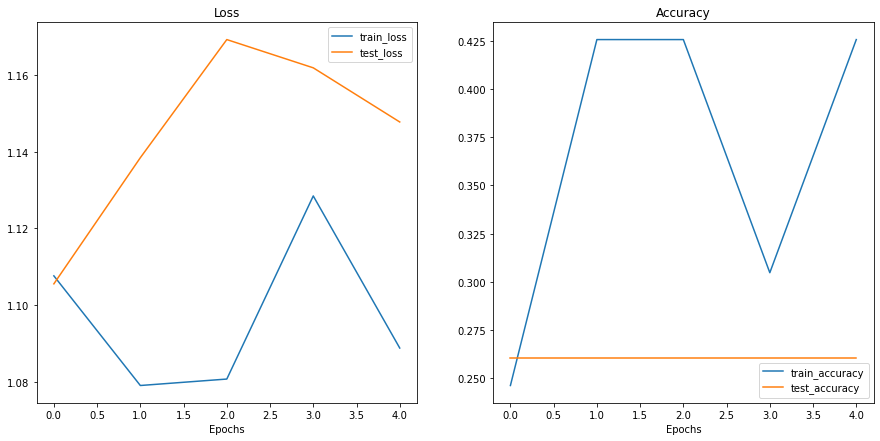

In [76]:
plot_loss_curves(model_1_results)

哇...

这些看起来也不是很好...

我们的模型是**欠拟合**还是**过拟合**？

或两者？

理想情况下，我们希望它具有更高的准确性和更低的损失，对吧？

您可以尝试使用哪些方法来实现这些目标？

## 10. Compare model results

Even though our models our performing quite poorly, we can still write code to compare them.

Let's first turn our model results in pandas DataFrames.

In [80]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107833,0.257812,1.136041,0.260417
1,1.084713,0.425781,1.162014,0.197917
2,1.115697,0.292969,1.169704,0.197917
3,1.095564,0.414062,1.138374,0.197917
4,1.098520,0.292969,1.142634,0.197917


And now we can write some plotting code using `matplotlib` to visualize the results of `model_0` and `model_1` together.

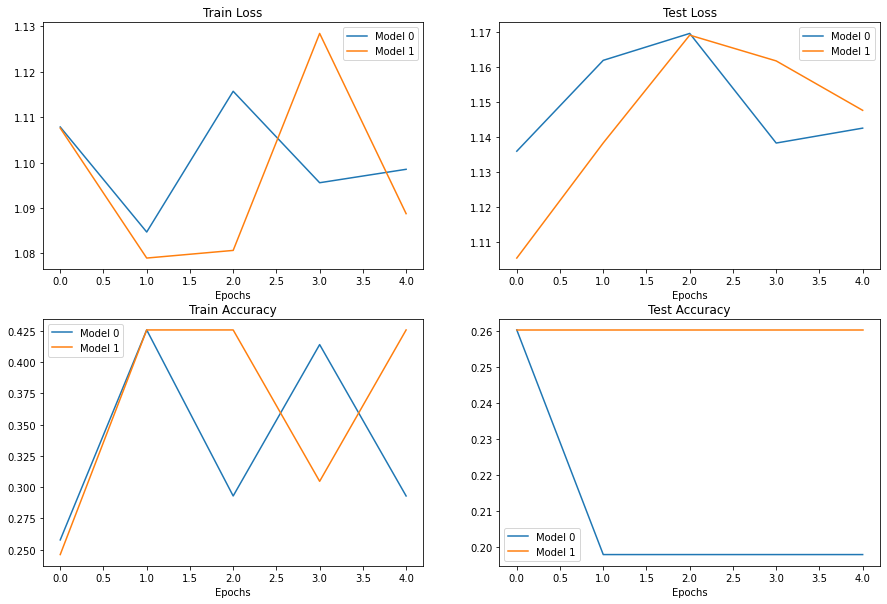

In [81]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

看起来我们的模型都表现同样糟糕，而且有点零星（指标急剧上升和下降）。

如果您构建了“model_2”，您会采取哪些不同的方式来尝试提高性能？

## 11. Make a prediction on a custom image

如果您已经在某个数据集上训练了模型，那么您很可能希望对自己的自定义数据进行预测。

在我们的例子中，既然我们已经在比萨、牛排和寿司图像上训练了一个模型，那么我们如何使用我们的模型对我们自己的图像进行预测呢？

为此，我们可以加载图像，然后**以与我们的模型训练的数据类型相匹配的方式对其进行预处理**。

换句话说，我们必须将我们自己的自定义图像转换为张量，并在将其传递给我们的模型之前确保它的数据类型正确。

让我们从下载自定义图像开始。

由于我们的模型预测图像中是否包含披萨、牛排或寿司，让我们下载一张 [my Dad giving two thumbs up to a big pizza from the Learn PyTorch for Deep Learning GitHub] 的照片（https://github.com/mrdbourke/ pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg）。

我们使用 Python 的 `requests` 模块下载图像。

> **Note:** If you're using Google Colab, you can also upload an image to the current session by going to the left hand side menu -> Files -> Upload to session storage. Beware though, this image will delete when your Google Colab session ends.


In [83]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

data\04-pizza-dad.jpeg already exists, skipping download.


### 11.1 Loading in a custom image with PyTorch

出色的！

看起来我们已经下载了一个自定义图像并准备好在 `data/04-pizza-dad.jpeg` 中使用。

是时候加载它了。

PyTorch的`torchvision`有几种输入输出（简称“IO”或“io”）方法，在[`torchvision.io`](https://pytorch.org/vision/stable/io.html).

由于我们要加载图像，我们将使用 [`torchvision.io.read_image()`](https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image)。

此方法将读取 JPEG 或 PNG 图像并将其转换为 3 维 RGB 或灰度“torch.Tensor”，其数据类型为“uint8”，范围为“[0, 255]”。

让我们试试看。

In [84]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 175, 181,  ...,  21,  18,  14],
         [146, 167, 180,  ...,  21,  18,  15],
         [124, 146, 171,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 189, 193,  ...,  22,  19,  15],
         [163, 181, 194,  ...,  22,  19,  16],
         [141, 163, 185,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 106, 104, 102],
         [ 47,  38,  24,  ..., 108, 105, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[117, 138, 145,  ...,  17,  14,  10],
         [109, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  54,  52,  50],
         [ 27,  18,   4,  ...,  50,  47,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

好的！ 看起来我们的图像是张量格式，但是，这种图像格式与我们的模型兼容吗？

我们的 `custom_image` 张量的数据类型为 `torch.uint8`，其值介于 `[0, 255]` 之间。

但我们的模型采用数据类型为“torch.float32”且值介于“[0, 1]”之间的图像张量。

因此，在我们将自定义图像与模型一起使用之前，**我们需要将其转换为与模型训练数据相同的格式**。

如果我们不这样做，我们的模型就会出错。

In [65]:
# Try to make a prediction on image in uint8 format (this will error)
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same

如果我们尝试对与我们的模型训练的数据类型不同的图像进行预测，我们会收到如下错误：

> `RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same`

让我们通过将我们的自定义图像转换为与我们的模型训练时相同的数据类型（`torch.float32`）来解决这个问题。

In [85]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6863, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6549, 0.7059,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6706,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7412, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7098, 0.7608,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7255,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4157, 0.4078, 0.4000],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4118, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4588, 0.5412, 0.5686,  ..., 0.0667, 0.0549, 0.0392],
         [0.4275, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

### 11.2 Predicting on custom images with a trained PyTorch model

漂亮，看起来我们的图像数据现在的格式与我们的模型训练时的格式相同。

除了一件事...

它是“形状”。

我们的模型是在形状为“[3,64,64]”的图像上训练的，而我们的自定义图像目前是“[3,4032,3024]”。

我们如何确保我们的自定义图像与我们的模型训练时的图像形状相同？

是否有任何可以提供帮助的`torchvision.transforms`？

在我们回答这个问题之前，让我们用 `matplotlib` 绘制图像以确保它看起来不错，记住我们必须将尺寸从 `CHW` 置换为 `HWC` 以适应 `matplotlib` 的要求。

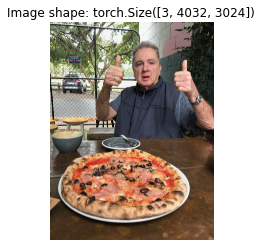

In [86]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

太棒了！

现在我们如何才能让我们的图像与我们的模型训练时的图像大小相同？

一种方法是使用`torchvision.transforms.Resize()`。

让我们组成一个转换管道来做到这一点。

In [87]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


呜呼！

最后让我们对我们自己的自定义图像进行预测。

In [69]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper___slow_conv2d_forward)

哦，我的天啊...

尽管我们做好了准备，但我们的自定义图像和模型在不同的设备上。

我们得到错误：
> `RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper___slow_conv2d_forward)`

让我们通过将 `custom_image_transformed` 放在目标设备上来解决这个问题。

In [70]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

现在怎么办？

看起来我们遇到了形状错误。

为什么会这样？

我们将自定义图像转换为与模型训练时使用的图像大小相同...

等一下...

我们忘记了一个维度。

批量大小。

我们的模型期望图像张量在开始时具有批量大小（“NCHW”，其中“N”是批量大小）。

除了我们的自定义图像目前只有“CHW”。

我们可以使用 `torch.unsqueeze(dim=0)` 添加一个批量大小维度来为我们的图像添加一个额外的维度并*最终*进行预测。

本质上，我们将告诉我们的模型对单个图像（“batch_size”为 1 的图像）进行预测。

In [88]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


是的！！！

看起来它奏效了！

> **注意：** 我们刚刚讨论了三个经典且最常见的深度学习和 PyTorch 问题：
> 1. **错误的数据类型** - 我们的模型需要 `torch.float32`，而我们的原始自定义图像是 `uint8`。
> 2. **错误的设备** - 我们的模型在目标“设备”（在我们的例子中是 GPU）上，而我们的目标数据尚未移动到目标“设备”。
> 3. **错误的形状** - 我们的模型期望输入图像的形状为 `[N, C, H, W]` 或 `[batch_size, color_channels, height, width]`，而我们的自定义图像张量的形状为` [颜色通道，高度，宽度]`。
>
> 请记住，这些错误不仅仅用于预测自定义图像。
>
> 它们将与您处理的几乎所有类型的数据类型（文本、音频、结构化数据）和问题一起出现。

现在让我们看看我们的模型的预测。

In [89]:
custom_image_pred

tensor([[ 0.1126,  0.0296, -0.1405]], device='cuda:0')

好吧，这些仍然是 *logit 形式*（模型的原始输出称为 logits）。

让我们将它们从 logits -> 预测概率 -> 预测标签转换。

In [90]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.1126,  0.0296, -0.1405]], device='cuda:0')
Prediction probabilities: tensor([[0.3708, 0.3413, 0.2879]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


好吧！

看起来不错。

但是当然我们的预测标签仍然是索引/张量形式。

我们可以通过在 `class_names` 列表上建立索引将其转换为字符串类名预测。

In [91]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'pizza'

哇。

看起来模型得到了正确的预测，即使它基于我们的评估指标表现不佳。

> **注意：**无论给出什么图像，当前形式的模型都会预测“pizza”、“steak”或“sushi”。 如果您希望您的模型在不同的类别上进行预测，则必须对其进行训练才能做到这一点。

但是如果我们检查 `custom_image_pred_probs`，我们会注意到模型对每个类的权重几乎相等（值相似）。

In [92]:
# The values of the prediction probabilities are quite similar
custom_image_pred_probs

tensor([[0.3708, 0.3413, 0.2879]], device='cuda:0')

具有如此相似的预测概率可能意味着几件事：
1. 模型试图同时预测所有三个类别（可能存在包含比萨、牛排和寿司的图像）。
2. 模型并不真正知道它想要预测什么，而只是为每个类分配相似的值。

我们的案例是 2 号，因为我们的模型训练不足，它基本上是在*猜测*。

### 11.3 Putting custom image prediction together: building a function

每次您想对自定义图像进行预测时，执行上述所有步骤很快就会变得乏味。

因此，让我们将它们放在一个函数中，我们可以轻松地反复使用它们。

具体来说，让我们创建一个函数：
1. 获取目标图像路径并转换为我们模型的正确数据类型（`torch.float32`）。
2. 确保目标图像像素值在“[0, 1]”范围内。
3. 必要时变换目标图像。
4. 确保模型在目标设备上。
5. 使用经过训练的模型对目标图像进行预测（确保图像尺寸正确且与模型在同一设备上）。
6. 将模型的输出 logits 转换为预测概率。
7. 将预测概率转换为预测标签。
8. 将目标图像与模型预测和预测概率一起绘制。

几步之遥，但我们已经做到了！

In [93]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

What a nice looking function, let's test it out.

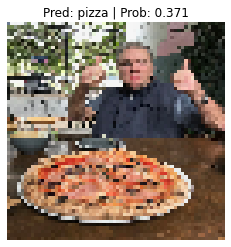

In [94]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

再次竖起两个大拇指！

看起来我们的模型只是通过猜测就得到了正确的预测。

但是，其他图像并非总是如此……

图像也被像素化了，因为我们使用 `custom_image_transform` 将其大小调整为 `[64, 64]`。

> **练习：** 尝试使用您自己的比萨、牛排或寿司图像进行预测，看看会发生什么。

## 主要内容

我们已经在这个模块中介绍了相当多的内容。

让我们用几个点来总结一下。

* PyTorch 有许多内置函数来处理各种数据，从视觉到文本到音频到推荐系统。
* 如果 PyTorch 的内置数据加载功能不符合您的要求，您可以编写代码通过继承 `torch.utils.data.Dataset` 来创建自己的自定义数据集。
* PyTorch 中的 `torch.utils.data.DataLoader` 有助于将您的 `Dataset` 转换为可在训练和测试模型时使用的可迭代对象。
* 很多机器学习都在处理 **overfitting** 和 **underfitting** 之间的平衡（我们在上面讨论了不同的方法，所以一个很好的练习是研究更多并编写代码来尝试不同的技术）。
* 可以使用经过训练的模型对您自己的自定义数据进行预测，只要您将数据格式化为与模型训练所基于的格式相似的格式。确保你处理好 PyTorch 和深度学习的三大错误：
    1. **错误的数据类型** - 当您的数据是 `torch.uint8` 时，您的模型需要 `torch.float32`。
    2. **错误的数据形状** - 当您的数据是 `[color_channels, height, width]` 时，您的模型需要 `[batch_size, color_channels, height, width]`。
    3. **错误的设备** - 您的模型在 GPU 上，但您的数据在 CPU 上。

## Exercises

All of the exercises are focused on practicing the code in the sections above.

You should be able to complete them by referencing each section or by following the resource(s) linked.

All exercises should be completed using [device-agnostic code](https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code).

**Resources:**
* [Exercise template notebook for 04](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb)
* [Example solutions notebook for 04](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/04_pytorch_custom_datasets_exercise_solutions.ipynb) (try the exercises *before* looking at this)

1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.
2. Recreate the data loading functions we built in sections 1, 2, 3 and 4. You should have train and test `DataLoader`'s ready to use.
3. Recreate `model_0` we built in section 7.
4. Create training and testing functions for `model_0`.
5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
    * Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 
6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?
7. Double the data you're using with your model and train it for 20 epochs, what happens to the results?
    * **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
    * You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.
8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) and share your prediction. 
    * Does the model you trained in exercise 7 get it right? 
    * If not, what do you think you could do to improve it?

## Extra-curriculum

* To practice your knowledge of PyTorch `Dataset`'s and `DataLoader`'s through PyTorch [datasets and dataloaders tutorial notebook](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).
* Spend 10-minutes reading the [PyTorch `torchvision.transforms` documentation](https://pytorch.org/vision/stable/transforms.html).
    * You can see demos of transforms in action in the [illustrations of transforms tutorial](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#illustration-of-transforms). 
* Spend 10-minutes reading the PyTorch [`torchvision.datasets` documentation](https://pytorch.org/vision/stable/datasets.html).
    * What are some datasets that stand out to you?
    * How could you try building a model on these?
* [TorchData is currently in beta](https://pytorch.org/data/beta/index.html) (as of April 2022), it'll be a future way of loading data in PyTorch, but you can start to check it out now. 
* To speed up deep learning models, you can do a few tricks to improve compute, memory and overhead computations, for more read the post [*Making Deep Learning Go Brrrr From First Principles*](https://horace.io/brrr_intro.html) by Horace He. 